In [20]:
# Plan of Action
# plot all tackle distance data to determine methodology for picking playmaking threshold
    # Find distance between tackler and ball when ball carrier gets ball
# come up with cone of influence equation 
# distance delta pipeline


 #cone is where the defender could make the tackle

# ONLY LOOK AT RUN PLAYS FOR NOW
# Chase down efficiency
    # How well does each defender's cone move towards the ball carrier
        # Have a minimum distance to be able to be considered for the play
            # distribution of tackler's distance moved from play, get the upper quartile as the min distance
        # How do we judge how effectively they move there?
            # is it just distance delta?
                # consider derivative of distance over time as metric in concern
            # is it moving to final tackle location
            # is it cone overlap delta?

# Once cone overlap reaches threshold, chaser converts to prospective tackler
    # Use this to consider conversion rates for chasers

# Tackle probability - for all prospective tacklers
    # after ball carrier is in cone, how well does tackler make tackle
        # cone overlap integral
        # how fast does cone overlap area increase
        # 
##

#bivariate distribution - x is normally distributed, y is skewed distributed
# these distributions are centered on the player's location and have stdev of some formula of velocity and weight
#the combined distribution comes from multipying the x and y distribution because we're assuming independence


In [21]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import math

In [22]:
# Game info - id, week, date, time, teams, scores
games = pd.read_csv("games.csv")


In [23]:
plays = pd.read_csv("plays.csv")
plays['gameClockSeconds'] = pd.to_datetime(plays['gameClock'], format='%M:%S').dt.minute * 60 + pd.to_datetime(plays['gameClock'], format='%M:%S').dt.second
plays.sort_values(by=["gameId", "quarter", "gameClockSeconds"], ascending=[True, True, False], inplace=True)
# plays.head()
# print(plays[["gameId", "gameClockSeconds"]])
plays['penaltyYards'].fillna(0, inplace=True)
plays['passLength'].fillna(0, inplace=True)

plays['passResult'] = plays['passResult'].replace('R', 'Q')
plays['passResult'] = plays['passResult'].fillna('R')
print(plays['passResult'])
print(plays.columns)

4889     C
2819     Q
7700     R
6265     C
3627     R
        ..
11770    R
11622    R
1888     R
9338     R
1576     R
Name: passResult, Length: 12486, dtype: object
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [24]:
plays.drop("gameClock", axis=1, inplace=True)
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4889,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2819,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7700,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6265,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3627,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [25]:
players = pd.read_csv("players.csv")
players['birthDate'] = pd.to_datetime(players['birthDate'])
reference_date = dt(2022, 9, 8)
players['age'] = players['birthDate'].apply(lambda x: reference_date.year - x.year - ((reference_date.month, reference_date.day) < (x.month, x.day)))
players.drop('birthDate', axis = 1, inplace=True)
players.drop('collegeName', axis = 1, inplace=True)
players.head()

,nflId,height,weight,position,displayName,age
0,25511,6-4,225,QB,Tom Brady,45.0
1,29550,6-4,328,T,Jason Peters,40.0
2,29851,6-2,225,QB,Aaron Rodgers,38.0
3,30842,6-6,267,TE,Marcedes Lewis,38.0
4,33084,6-4,217,QB,Matt Ryan,37.0


In [26]:
tackles = pd.read_csv("tackles.csv")
tackles_with_names = pd.merge(tackles, players[['nflId', 'displayName']], on='nflId', how='left')
# Drop the nflId column if it's no longer needed
#tackles_with_names.drop('nflId', axis=1, inplace=True)
tackles = tackles_with_names
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,displayName
0,2022090800,101,42816,1,0,0,0,Troy Hill
1,2022090800,393,46232,1,0,0,0,Tim Settle
2,2022090800,486,40166,1,0,0,0,Jordan Poyer
3,2022090800,646,47939,1,0,0,0,Justin Hollins
4,2022090800,818,40107,1,0,0,0,Micah Hyde


In [66]:
w1 = pd.read_csv("tracking_week_1.csv")
w2 = pd.read_csv("tracking_week_2.csv")
w3 = pd.read_csv("tracking_week_3.csv")
w4 = pd.read_csv("tracking_week_4.csv")
w5 = pd.read_csv("tracking_week_5.csv")
w6 = pd.read_csv("tracking_week_6.csv")
w7 = pd.read_csv("tracking_week_7.csv")
w8 = pd.read_csv("tracking_week_8.csv")
w9 = pd.read_csv("tracking_week_9.csv")

In [67]:
all_weeks = pd.concat([w1, w2, w3, w4, w5, w6, w7, w8, w9])
all_weeks.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


In [29]:
# want ballcarrier data for each play
# player name, player id, gameid, playid, x, y, s, etc. for all the moments that they have recieved the ball from the qb
temp = w1
temp.dropna(subset=['event'], inplace=True)
# Assuming your DataFrame is named df and contains the 'event' column

# Filtering to get rows where 'event' column doesn't contain 'pass', 'tackle', or 'contact'
filtered_events = temp[~temp['event'].str.contains('pass|tackle|contact', na=False, case=False)]['event']

# Displaying the unique filtered events
unique_filtered_events = filtered_events.unique()
print(unique_filtered_events)

#temp = temp[~temp['event'].str.contains('tackle', na=False)]['event']
# temp = temp[~temp['event'].str.contains('contact', na=False)]['event']
# type(w1.iloc[1,16])
w1[w1['event'] == 'run']
plays[plays["playId"] == 101][plays["gameId"] == 2022090800]

['run' 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'lateral' 'line_set' 'qb_slide' 'shift' 'qb_sack'
 'autoevent_ballsnap' 'snap_direct' 'fumble_defense_recovered'
 'fumble_offense_recovered']


/var/folders/np/sw1hsvrj14x94rqhvr0cg5280000gn/T/ipykernel_59568/470345304.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plays[plays["playId"] == 101][plays["gameId"] == 2022090800]


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
7700,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,834


In [30]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [31]:
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4889,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2819,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7700,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6265,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3627,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [38]:
#calculate distance threshold

# array storing the distance from the tackler to the point of reception/handoff at the moment of play start
all_start_dists = []
play_nums = []

for index, play in tackles.iterrows(): 
    current_game_id = play['gameId']
    current_play_id = play['playId']
    if (plays[(plays['gameId'] == current_game_id) & (plays['playId'] == current_play_id)]['passResult'].values[0] != 'R'):
        continue
    tackler_id = play['nflId']
    ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
    current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
    
    #from current_play, filter out ballcarrier, football, tackler
    #then find where ballcarrier pos = football pos
    current_play = current_play[(current_play["nflId"] == tackler_id) | (current_play["nflId"] == ball_carrier_id) | (current_play["displayName"] == 'football')]
    frame = 0
    min_dist = 100

    # saves the following at moment of reception/handoff: 
    #   [ball_carrier_x, ball_carrier_y, football_x, football_y, frame #]
    min_dist_positions = [-1, -1, -1, -1, -1]
    # print("play: ", index)
    for i in range(1,max(current_play['frameId'])):
        try:
            curr_frame = current_play[current_play['frameId'] == i]
            ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
            ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
            football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
            football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
            
            dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
            if dist < min_dist:
                min_dist = dist
                min_dist_positions[0] = ball_carrier_x
                min_dist_positions[1] = ball_carrier_y
                min_dist_positions[2] = football_x
                min_dist_positions[3] = football_x
                min_dist_positions[4] = i
                if dist < .3:
                    break
        except:
            continue

    curr_frame = current_play[current_play['frameId'] == min_dist_positions[4]]
    curr_frame = curr_frame[curr_frame["nflId"] == tackler_id]
    try:
        tackler_x = curr_frame.iloc[0, 9]
        tackler_y = curr_frame.iloc[0, 10]
        play_nums.append((current_game_id, current_play_id))
        all_start_dists.append(math.dist([min_dist_positions[0], min_dist_positions[1]], [tackler_x, tackler_y]))
    except:
        continue
    
for entry in all_start_dists:
    print(entry)


1.6743058263053388
0.9349331526906074
0.6673080248281157
0.8626702730475937
9.074387031640203
0.7151223671512466
0.8159656855530167
0.9234717104492184
0.6010823570859497
9.778445684258825
1.4527904184706026
1.2050726119201352
0.8664871608973862
8.136098573640806
0.7433034373659257
2.2780035118497906
16.81035692660926
6.854786648758664
13.103667425572127
4.134174645561074
6.355194725576864
0.8605230967266358
1.2731457104353767
1.024499877989254
1.262101422231984
5.773387220687699
0.9546203433826452
4.389829153850978
17.127387424823432
0.7463243262818069
2.1000952359357505
4.637456199254069
1.0741508273980902
13.229984882833383
20.27613621970419
1.1322985472038725
1.1472575996697498
1.592607924129475
9.523702011297917
0.9264987857520359
1.1799152511939168
0.3280243893371325
0.5456189146281586
1.5352198539622885
1.1655899793666766
0.6067124524847003
4.647590773723518
5.155938323913498
0.49365980188789804
10.391544639754
7.471934153885456
9.619615376926465
0.366878726556884
15.587767640043

In [40]:
# After running previous cell, all_start_dists has all the distances from ball carrier to tackler at playstart
# TODO: get distribution of start dist data, store 3rd quartile

all_start_dists = np.array(all_start_dists)

# print(all_start_dists)

quartile_3 = np.percentile(all_start_dists, 75)
quartile_1 = np.percentile(all_start_dists, 25)

print(quartile_1, quartile_3)
#2.3998176158978235 8.170188186099834

3.493171866498334 8.146397949487074


In [45]:
print((play_nums))

[(2022090800, 101), (2022090800, 393), (2022090800, 1736), (2022090800, 3145), (2022090800, 3362), (2022091100, 1260), (2022091100, 2114), (2022091100, 2353), (2022091100, 2512), (2022091100, 2640), (2022091100, 2878), (2022091100, 2899), (2022091100, 3778), (2022091101, 2051), (2022091101, 3221), (2022091102, 86), (2022091102, 531), (2022091102, 1493), (2022091102, 2065), (2022091102, 2352), (2022091102, 4102), (2022091103, 520), (2022091103, 1037), (2022091103, 1315), (2022091103, 1672), (2022091103, 2222), (2022091104, 999), (2022091104, 2269), (2022091104, 2781), (2022091104, 2974), (2022091105, 228), (2022091105, 667), (2022091105, 1913), (2022091106, 154), (2022091106, 607), (2022091106, 1874), (2022091106, 2584), (2022091106, 2767), (2022091106, 2935), (2022091107, 275), (2022091107, 959), (2022091107, 1696), (2022091107, 1841), (2022091107, 2659), (2022091107, 3398), (2022091109, 888), (2022091109, 1636), (2022091109, 1729), (2022091109, 2404), (2022091110, 543), (2022091110, 1

In [68]:
"""
df needs: for all runs we want:
    plays.csv:
        
    all_weeks:
        
"""

df = all_weeks.merge(plays, on=['gameId', 'playId'], how='outer')

In [69]:
df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,...,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN,900
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,...,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN,900
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,...,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN,900
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,...,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN,900
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,...,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN,900


In [50]:
temp_key = pd.MultiIndex.from_tuples(play_nums, names=['gameId', 'playId'])
# Filter the DataFrame
df = df.set_index(['gameId', 'playId']).loc[df.set_index(['gameId', 'playId']).index.isin(temp_key)].reset_index()
df.head()

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [55]:
print(df['playDescription'].unique())

['(13:54) D.Singletary right end to BUF 45 for 7 yards (T.Hill).'
 '(12:33) (Shotgun) D.Singletary left tackle to LA 47 for 2 yards (As.Robinson; B.Wagner).'
 '(11:20) Z.Moss right end to LA 34 for 1 yard (T.Lewis, G.Gaines).' ...
 '(2:00) (Shotgun) K.Drake right end to NO 45 for 4 yards (K.Elliss).'
 '(1:15) (Shotgun) K.Drake left end to BLT 48 for -7 yards (C.Granderson).'
 '(:23) (Shotgun) D.Washington right guard to NO 16 for 5 yards (B.Washington).']


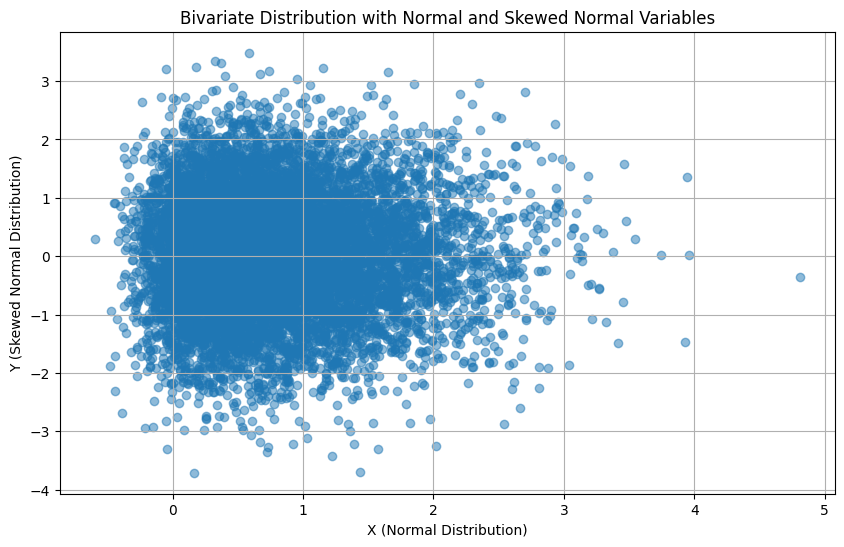

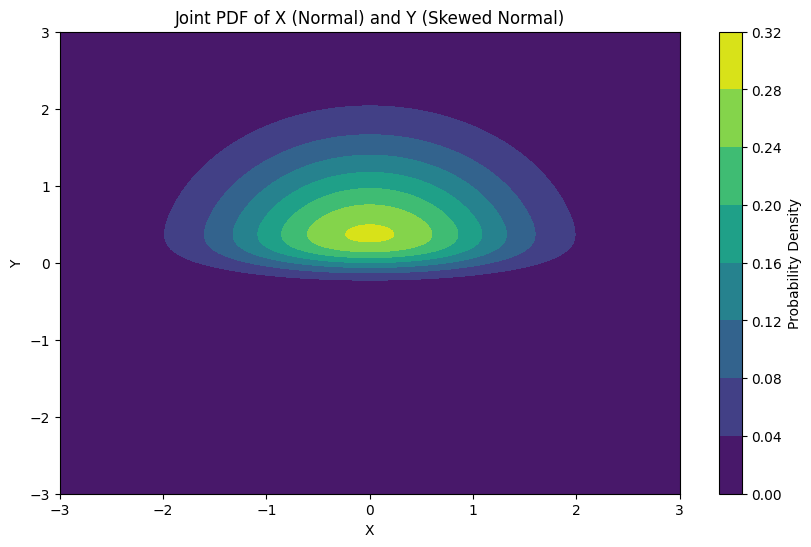

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Number of samples
n = 10000

# Generate a normal distribution for x
y = np.random.normal(0, 1, n)

# Generate a skewed normal distribution for y
# Here, 'a' is the skewness parameter
a = 5
x = skewnorm.rvs(a, size=n)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title("Bivariate Distribution with Normal and Skewed Normal Variables")
plt.xlabel("X (Normal Distribution)")
plt.ylabel("Y (Skewed Normal Distribution)")
plt.grid(True)
plt.show()

x_points = np.linspace(-3, 3, 1000)
y_points = np.linspace(-3, 3, 1000)

# Calculating the PDFs of X and Y at these points
pdf_x_points = norm.pdf(x_points, loc = 0, scale = 1)
pdf_y_points = skewnorm.pdf(y_points, a)

# Creating a meshgrid for the joint distribution
X, Y = np.meshgrid(x_points, y_points)
joint_pdf = np.outer(pdf_y_points, pdf_x_points)

# Plotting the joint PDF
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, joint_pdf, cmap="viridis")
plt.colorbar(label='Probability Density')
plt.title("Joint PDF of X (Normal) and Y (Skewed Normal)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

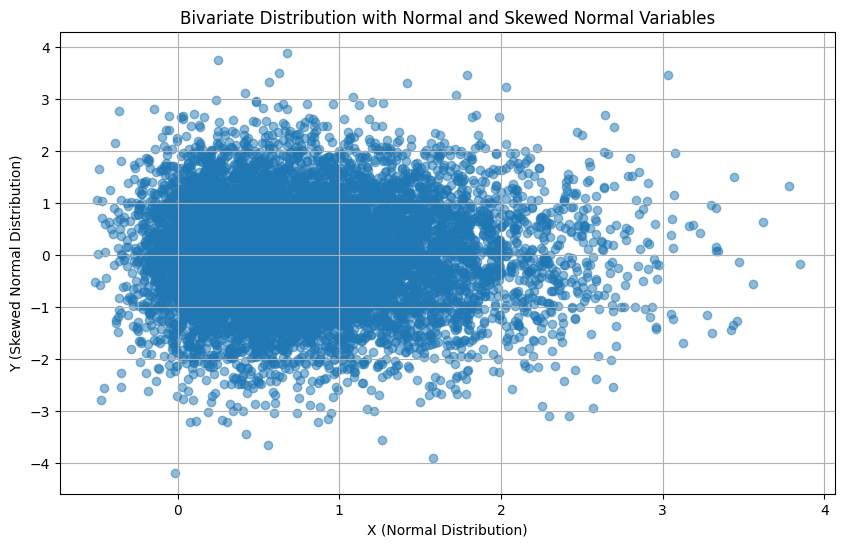

[3.25383314e-53 5.20604164e-53 8.32174465e-53 1.32897108e-52
 2.12036718e-52 3.37987803e-52 5.38251684e-52 8.56375413e-52
 1.36124849e-51 2.16174801e-51 3.42978715e-51 5.43655418e-51
 8.60943653e-51 1.36213515e-50 2.15307989e-50 3.40012253e-50
 5.36442868e-50 8.45564764e-50 1.33157238e-49 2.09496701e-49
 3.29294223e-49 5.17113123e-49 8.11300112e-49 1.27166304e-48
 1.99139361e-48 3.11556432e-48 4.86979740e-48 7.60465705e-48
 1.18643227e-47 1.84927223e-47 2.87974040e-47 4.48023123e-47
 6.96373325e-47 1.08138026e-46 1.67768096e-46 2.60036877e-46
 4.02675446e-46 6.22974116e-46 9.62896287e-46 1.48690659e-45
 2.29394253e-45 3.53570531e-45 5.44457867e-45 8.37620297e-45
 1.28743352e-44 1.97695667e-44 3.03294273e-44 4.64864094e-44
 7.11840243e-44 1.08901490e-43 1.66448491e-43 2.54167884e-43
 3.87753977e-43 5.90998848e-43 8.99936368e-43 1.36908930e-42
 2.08087773e-42 3.15977508e-42 4.79358697e-42 7.26540609e-42
 1.10015538e-41 1.66434372e-41 2.51551485e-41 3.79844314e-41
 5.73032513e-41 8.636699

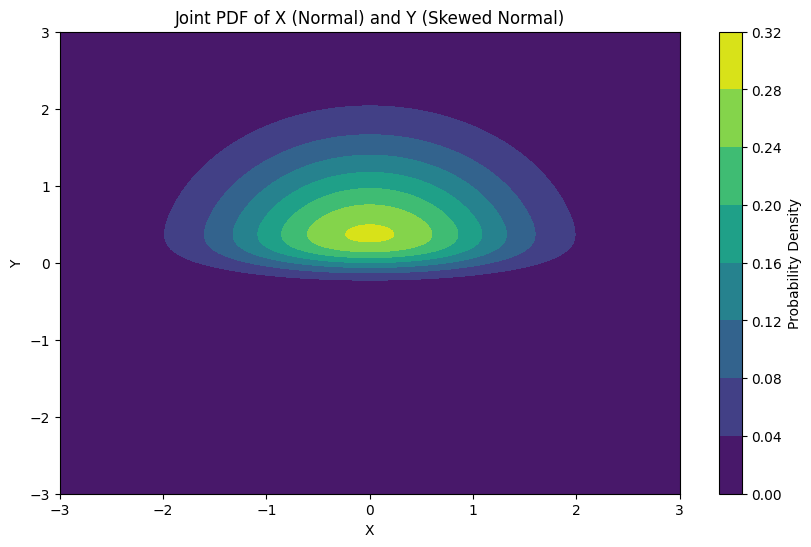

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Number of samples
n = 10000

# Generate a normal distribution for x
y = np.random.normal(0, 1, n)

# Generate a skewed normal distribution for y
# Here, 'a' is the skewness parameter
a = 5
x = skewnorm.rvs(a, size=n)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title("Bivariate Distribution with Normal and Skewed Normal Variables")
plt.xlabel("X (Normal Distribution)")
plt.ylabel("Y (Skewed Normal Distribution)")
plt.grid(True)
plt.show()

x_points = np.linspace(-3, 3, 1000)
y_points = np.linspace(-3, 3, 1000)

# Calculating the PDFs of X and Y at these points
pdf_x_points = norm.pdf(x_points)
pdf_y_points = skewnorm.pdf(y_points, a)
print(pdf_y_points)
# Creating a meshgrid for the joint distribution
X, Y = np.meshgrid(y_points, x_points)
joint_pdf = np.outer(pdf_y_points, pdf_x_points)
# Plotting the joint PDF
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, joint_pdf, cmap="viridis")
plt.colorbar(label='Probability Density')
plt.title("Joint PDF of X (Normal) and Y (Skewed Normal)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()